# Model Validation


## Simulation Setup

In this section, we outline the initial steps required to prepare our experimental environment. These steps are crucial for ensuring reproducibility and consistency across our research experiments.

### Step-by-Step Setup:

- Ensure all necessary dependencies are imported.
- Determine simulation parameters.
- Create and configure experiment instances tailored to our research needs.
- Facilitate seamless integration with analysis sections.


In [14]:
from pathlib import Path
from datetime import datetime
from collections import defaultdict

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns

from IPython.display import display, Markdown
from model.types.proposals import Proposal
from model.types.proposal_type import ProposalSubType, ProposalType
from model.utils.postprocessing import postprocessing
from model.utils.simulation import merge_simulation_results, save_execution_result, setup_simulation
from model.types.proposal_type import ProposalGeneration
from model.types.scenario import Scenario

out_path = Path("results/simulations/model_validation06.09.24.11.14")
out_path.mkdir(exist_ok=True)

In [2]:
pd.options.display.float_format = "{:.2f}".format
%matplotlib inline

### Simulation parameters


In [3]:
MONTE_CARLO_RUNS = 3
TIMESTEPS = 1000
# SEED = 141412
SEED = 53212
SIMULATION_TIME = datetime(2024, 9, 1)
SCENARIO = Scenario.HappyPath

proposal_types = ProposalType.Random
proposals = []
attackers = {}
defenders = {"0x3e40d73eb977dc6a537af587d48316fee66e9c8c"}

### Configuration


In [4]:
experiment, simulation_hashes = setup_simulation(
    TIMESTEPS,
    MONTE_CARLO_RUNS,
    SCENARIO,
    proposal_types,
    ProposalSubType.NoEffect,
    ProposalGeneration.Random,
    proposals,
    attackers,
    defenders,
    SEED,
    SIMULATION_TIME,
    out_path,
)
experiment.after_experiment = lambda experiment=None: save_execution_result(experiment, TIMESTEPS, out_path)

Skipping simulation 68f17f667a1188eb690b4f8082d95acf1bd2670917f90377efbb5bcadd34bbe3-1000 as it already exists with required files.
Skipping simulation 69f2c1897101591f10a2fd940477431831ca7a5e44eed591b72f07100a8b8831-1000 as it already exists with required files.
Skipping simulation 8009957e4134a9b6e5cacb6d71f8d4e990a96e0f4ca6b679957f5b35c59fa5d5-1000 as it already exists with required files.


### Simulation Execution


In [5]:
simulations = experiment.get_simulations()
if len(simulations) != 0:
    experiment.run()

result = merge_simulation_results(simulation_hashes, out_path)

### Plots

#### Processing

In [6]:
def open_actors_csv(simulation_hashes: list[str], out_path: Path):
    dfs: list = []
    simulation_counter = 0

    for hash in simulation_hashes:
        folder_path = out_path.joinpath(f"{hash}/")
        actors_file = folder_path / "actors.csv"

        actors_df = pd.read_csv(actors_file)

        actors_df["simulation"] = simulation_counter
        dfs.append(actors_df)
        simulation_counter += 1

    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df


post_processing = postprocessing(result)
actors_df = open_actors_csv(simulation_hashes, out_path)

In [7]:
# actors_df.drop(columns=actors_df.columns[0], inplace=True)
actors_df["total_coins_balance"] = actors_df.wstETH_balance + actors_df.st_eth_balance
actors_df["total_coins_locked"] = actors_df.wstETH_locked + actors_df.st_eth_locked
actors_df["actor_locked"] = actors_df["total_coins_locked"] > 0
actors_df["actor_locked"] = actors_df["total_coins_locked"] > 0
total_actors = len(actors_df.id.unique())

sum_by_actors = actors_df.groupby(by=["seed", "timestep"]).sum(numeric_only=True).reset_index()
sum_by_actors.drop(columns=["id", "last_locked_tx_timestamp"], inplace=True)
actors_df = actors_df.merge(sum_by_actors, on=["seed", "timestep"], suffixes=("", "_sum"))

actors_df["total_coins_balance_relative"] = (
    actors_df["total_coins_balance"] / actors_df["total_coins_balance_sum"]
).replace(np.nan, 0)
actors_df["total_coins_locked_relative"] = (
    actors_df["total_coins_locked"] / actors_df["total_coins_balance_sum"]
).replace(np.nan, 0)
actors_df["actor_locked_relative"] = actors_df["actor_locked"] / total_actors
actors_df["health_relative"] = actors_df["health"] / actors_df["initial_health_sum"]
actors_df["count"] = 1

In [8]:
result.columns

Index(['actors', 'lido', 'dual_governance', 'proposals',
       'non_initialized_proposals', 'time_manager', 'scenario', 'attackers',
       'defenders', 'proposal_types', 'proposal_subtypes', 'is_active_attack',
       'proposal_generation', 'seed', 'simulation', 'subset', 'run', 'substep',
       'timestep'],
      dtype='object')

In [9]:
result['dg_state'] = result.dual_governance.apply(lambda x: x.state.state)
result['dg_state_value'] = result['dg_state'].apply(lambda state: state.value)
result['dg_state_name'] = result['dg_state'].apply(lambda state: state.name)

In [10]:
result['dg_dynamic_timelock_hours'] = result.dual_governance.apply(lambda dg: dg.state._calc_dynamic_timelock_duration(dg.state.signalling_escrow.get_rage_quit_support()).to_seconds() / 60 / 60 / 24)

In [11]:
actors_df_summed_by_actors = actors_df.groupby(by=['seed', 'timestep']).sum(numeric_only=True).reset_index()
actors_df_summed_by_actors_rts = actors_df.groupby(by=['seed', 'timestep', 'reaction_time'], sort=False).sum(numeric_only=True).reset_index()

#### General plot

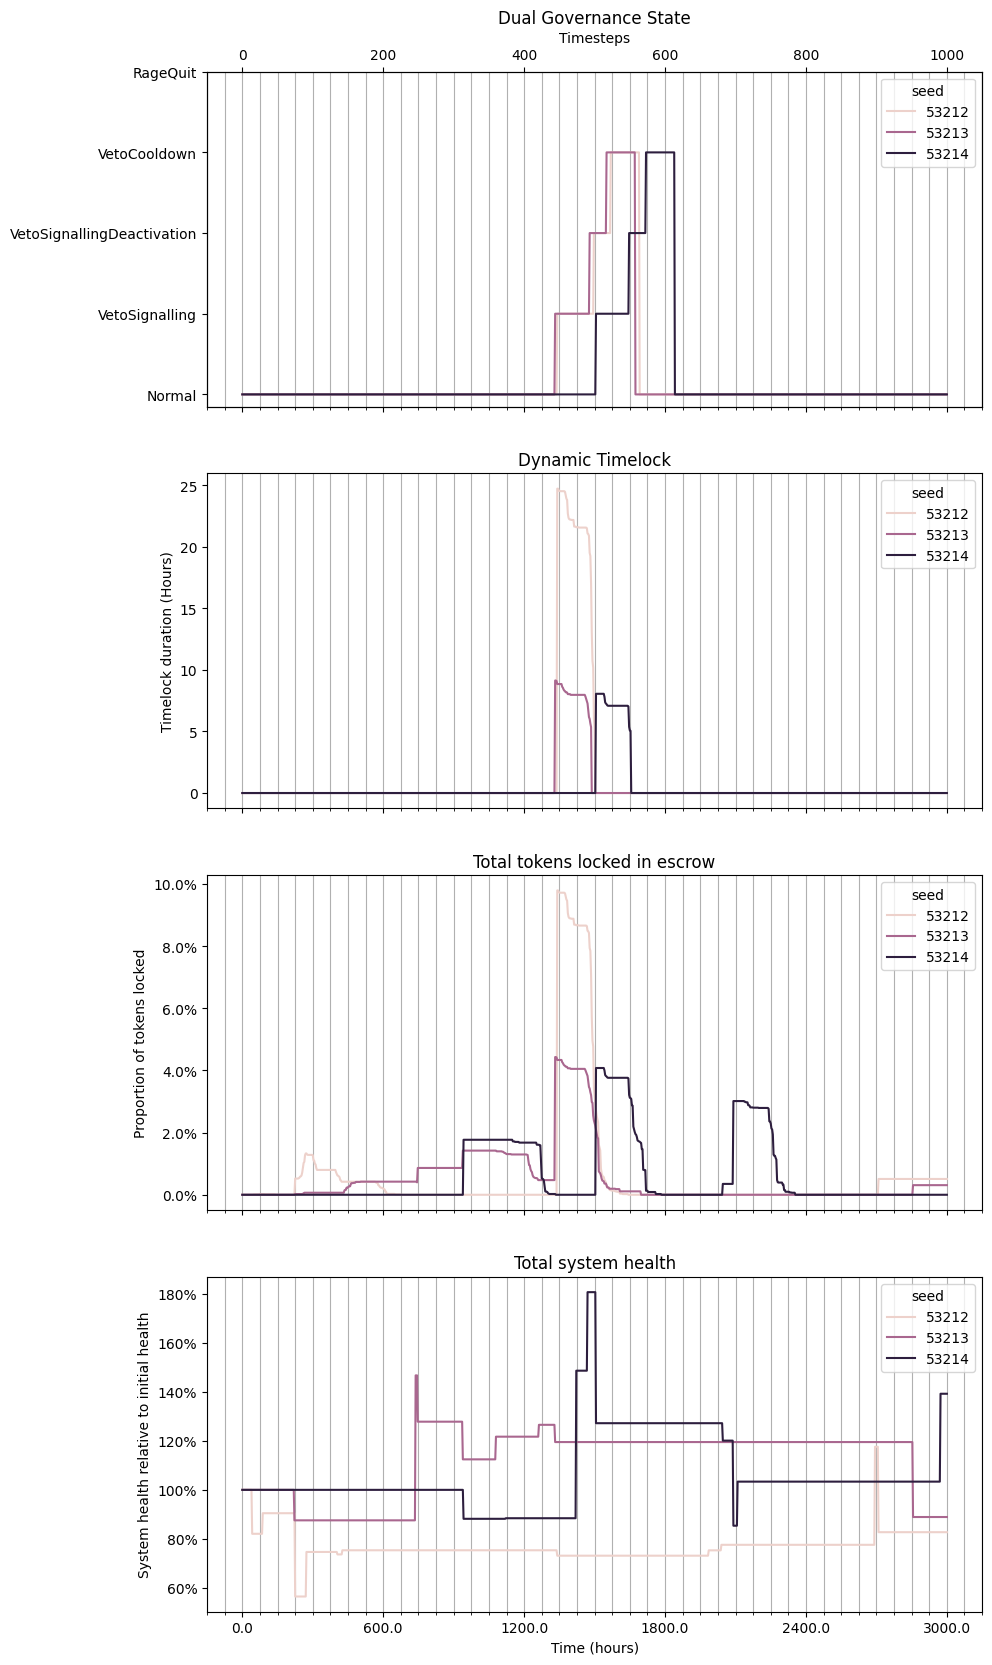

In [12]:
basesize = 5
n_plots = 4
fig, axes = plt.subplots(figsize=(basesize * 2, basesize * n_plots), nrows=n_plots, sharex=True)
sns.lineplot(result, x='timestep', y='dg_state_value', hue='seed', ax=axes[0])
state_names = {1: 'Normal', 2: 'VetoSignalling', 3: 'VetoSignallingDeactivation', 4: 'VetoCooldown', 5: 'RageQuit'}
axes[0].set_yticks(list(state_names.keys()), labels=list(state_names.values()));
axes[0].set_ylabel('');
axes[0].set_title('Dual Governance State')

sns.lineplot(result, x='timestep', y='dg_dynamic_timelock_hours', hue='seed', ax=axes[1])
axes[1].set_ylabel('Timelock duration (Hours)');
axes[1].set_title('Dynamic Timelock')

sns.lineplot(actors_df_summed_by_actors, x='timestep', y='total_coins_locked_relative', hue='seed', ax=axes[2])
axes[2].set_title('Total tokens locked in escrow')
axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
axes[2].set_ylabel('Proportion of tokens locked')

sns.lineplot(actors_df_summed_by_actors, x='timestep', y='health_relative', hue='seed', ax=axes[3])
axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
axes[3].set_title('Total system health')
axes[3].set_ylabel('System health relative to initial health')

axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(25))
axes[-1].set_xlabel('Time (hours)')

ax_twin = axes[0].twiny()
# ax2.grid(True)
ax_twin.set_xlabel('Timesteps')
ax_twin.set_xticks(axes[0].get_xticks())
ax_twin.set_xlim(axes[0].get_xlim())
for i in range(len(axes)):
    axes[i].grid(True, axis='x', which='both')

fig.savefig(out_path.joinpath('Lock dynamics' + '.png'), dpi=300)
fig.savefig(out_path.joinpath('Lock dynamics' + '.svg'), dpi=1000)

#### Individual plots

In [17]:
for seed in result.seed.unique():
    basesize = 5
    n_plots = 4
    fig, axes = plt.subplots(figsize=(basesize * 2, basesize * n_plots), nrows=n_plots, sharex=True)
    sns.lineplot(result[result['seed'] == seed], x='timestep', y='dg_state_value', ax=axes[0])
    state_names = {1: 'Normal', 2: 'VetoSignalling', 3: 'VetoSignallingDeactivation', 4: 'VetoCooldown', 5: 'RageQuit'}
    axes[0].set_yticks(list(state_names.keys()), labels=list(state_names.values()));
    axes[0].set_ylabel('');
    axes[0].set_title('Dual Governance State')
    
    sns.lineplot(result[result['seed'] == seed], x='timestep', y='dg_dynamic_timelock_hours', ax=axes[1])
    axes[1].set_ylabel('Timelock duration (Hours)');
    axes[1].set_title('Dynamic Timelock')
    
    sns.lineplot(actors_df_summed_by_actors[actors_df_summed_by_actors['seed'] == seed], x='timestep', y='total_coins_locked_relative', ax=axes[2])
    axes[2].set_title('Total tokens locked in escrow')
    axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[2].set_ylabel('Proportion of tokens locked')
    axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    axes[2].grid(True, axis='y', which='both')
    
    sns.lineplot(actors_df_summed_by_actors[actors_df_summed_by_actors['seed'] == seed], x='timestep', y='health_relative', ax=axes[3])
    axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[3].set_title('Total system health')
    axes[3].set_ylabel('System health relative to initial health')

    ### proposals
    simulation_start = result[(result['seed'] == seed) & (result['timestep'] == 0)].time_manager.apply(lambda tm: tm.current_time).iloc[0].timestamp()
    proposals_info = result[result['seed'] == seed].dual_governance.apply(lambda dg: dg.timelock.proposals.state.proposals).iloc[-1]
    proposal_dict = defaultdict(list)
    for proposal in proposals_info:
        proposal_dict['id'].append(proposal.id)
        proposal_dict['status'].append(proposal.status)
        proposal_dict['submittedAt'].append((proposal.submittedAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict['scheduledAt'].append((proposal.scheduledAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict['executedAt'].append((proposal.executedAt.to_seconds() - simulation_start) / 3600 / 3)
    proposal_df = pd.DataFrame(proposal_dict).set_index('id')
    for i in range(n_plots):
        for proposal_id in proposal_df.index:
            prop = proposal_df.loc[proposal_id]
            ylim = axes[i].get_ylim()
            dy = (ylim[1] - ylim[0]) * 0.1
            axes[i].plot(np.repeat(prop.submittedAt, 2), [ylim[0], ylim[0] + dy], color='orange')
            axes[i].set_ylim(ylim)
        axes[i].plot([],[], color='orange', label='Proposal submittion')
        axes[i].legend()
    ### proposals
    
    axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))
    axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(25))
    axes[-1].set_xlabel('Time (hours)')
    
    ax_twin = axes[0].twiny()
    # ax2.grid(True)
    ax_twin.set_xlabel('Timesteps')
    ax_twin.set_xticks(axes[0].get_xticks())
    ax_twin.set_xlim(axes[0].get_xlim())
    for i in range(len(axes)):
        axes[i].grid(True, axis='x', which='both')
    
    fig.savefig(out_path.joinpath(f'Lock dynamics (seed={seed})' + '.png'), dpi=300)
    fig.savefig(out_path.joinpath(f'Lock dynamics (seed={seed})' + '.svg'), dpi=1000)
    plt.close(fig)

#### Individual plots broken down by ReactionTime (unfinished)

In [18]:
for seed in result.seed.unique():
    basesize = 5
    n_plots = 4
    fig, axes = plt.subplots(figsize=(basesize * 2, basesize * n_plots), nrows=n_plots, sharex=True)
    sns.lineplot(result[result['seed'] == seed], x='timestep', y='dg_state_value', ax=axes[0])
    state_names = {1: 'Normal', 2: 'VetoSignalling', 3: 'VetoSignallingDeactivation', 4: 'VetoCooldown', 5: 'RageQuit'}
    axes[0].set_yticks(list(state_names.keys()), labels=list(state_names.values()));
    axes[0].set_ylabel('');
    axes[0].set_title('Dual Governance State')
    
    sns.lineplot(result[result['seed'] == seed], x='timestep', y='dg_dynamic_timelock_hours', ax=axes[1])
    axes[1].set_ylabel('Timelock duration (Hours)');
    axes[1].set_title('Dynamic Timelock')
    
    sns.lineplot(actors_df_summed_by_actors_rts[actors_df_summed_by_actors_rts['seed'] == seed], x='timestep', y='total_coins_locked_relative', hue='reaction_time', ax=axes[2])
    axes[2].set_title('Total tokens locked in escrow')
    axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[2].set_ylabel('Proportion of tokens locked')
    
    sns.lineplot(actors_df_summed_by_actors_rts[actors_df_summed_by_actors_rts['seed'] == seed], x='timestep', y='health_relative', hue='reaction_time', ax=axes[3])
    axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[3].set_title('Total system health')
    axes[3].set_ylabel('System health relative to initial health')

    ### proposals
    simulation_start = result[(result['seed'] == seed) & (result['timestep'] == 0)].time_manager.apply(lambda tm: tm.current_time).iloc[0].timestamp()
    proposals_info = result[result['seed'] == seed].dual_governance.apply(lambda dg: dg.timelock.proposals.state.proposals).iloc[-1]
    proposal_dict = defaultdict(list)
    for proposal in proposals_info:
        proposal_dict['id'].append(proposal.id)
        proposal_dict['status'].append(proposal.status)
        proposal_dict['submittedAt'].append((proposal.submittedAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict['scheduledAt'].append((proposal.scheduledAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict['executedAt'].append((proposal.executedAt.to_seconds() - simulation_start) / 3600 / 3)
    proposal_df = pd.DataFrame(proposal_dict).set_index('id')
    for i in range(n_plots):
        for proposal_id in proposal_df.index:
            prop = proposal_df.loc[proposal_id]
            ylim = axes[i].get_ylim()
            dy = (ylim[1] - ylim[0]) * 0.1
            axes[i].plot(np.repeat(prop.submittedAt, 2), [ylim[0], ylim[0] + dy], color='orange')
            axes[i].set_ylim(ylim)
        axes[i].plot([],[], color='orange', label='Proposal submittion')
        axes[i].legend()
    ### proposals
    
    axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))
    axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(25))
    axes[-1].set_xlabel('Time (hours)')
    
    ax_twin = axes[0].twiny()
    # ax2.grid(True)
    ax_twin.set_xlabel('Timesteps')
    ax_twin.set_xticks(axes[0].get_xticks())
    ax_twin.set_xlim(axes[0].get_xlim())
    for i in range(len(axes)):
        axes[i].grid(True, axis='x', which='both')
    
    fig.savefig(out_path.joinpath(f'Lock dynamics (seed={seed}) by ReactionTime' + '.png'), dpi=300)
    fig.savefig(out_path.joinpath(f'Lock dynamics (seed={seed}) by ReactionTime' + '.svg'), dpi=1000)
    plt.close(fig)

### Post processing


In [24]:
def create_donut_charts(dataframes, column_names, titles):
    num_bar_charts = len(dataframes)
    fig, axs = plt.subplots(1, num_bar_charts, figsize=(6 * num_bar_charts, 4))

    for i, df in enumerate(dataframes):
        values = df[column_names[i]]
        labels = [*df.index]
        total = sum(values)
        axs[i].pie(
            values,
            labels=labels,
            # colors=colors,
            autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
            startangle=140,
            wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
            textprops=dict(color="black", fontsize=10),
        )
        axs[i].set_title(titles[i])
        axs[i].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()
    return fig

### Wallets distributions


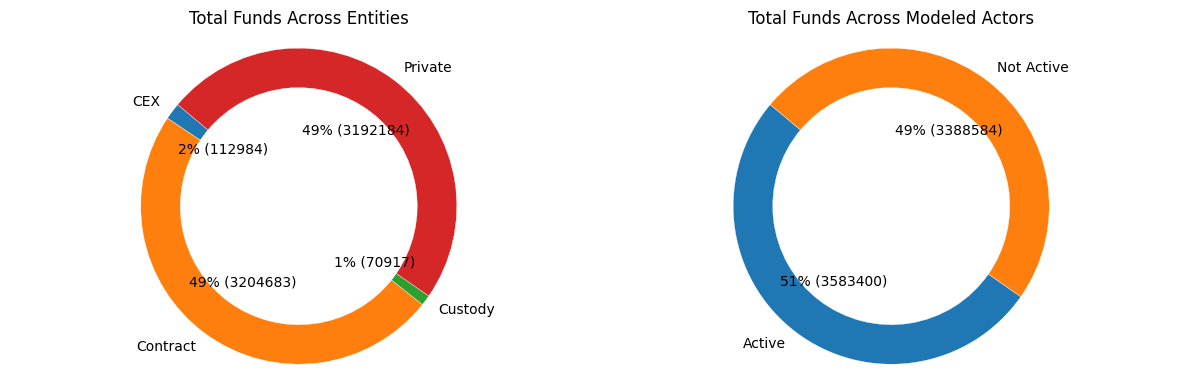

In [25]:
actors_start = actors_df[(actors_df["timestep"] == 0) & (actors_df["seed"] == SEED)].copy()
actors_start["is_private"] = "Active"
actors_start.loc[actors_start.entity.isin({"Contract", "CEX", "Custody"}), "is_private"] = "Not Active"

entity_summary = actors_start.groupby("entity").sum(numeric_only=True)
is_private_summary = actors_start.groupby("is_private").sum(numeric_only=True)

fig = create_donut_charts(
    [entity_summary, is_private_summary],
    ["total_coins_balance", "total_coins_balance"],
    ["Total Funds Across Entities", "Total Funds Across Modeled Actors"],
)

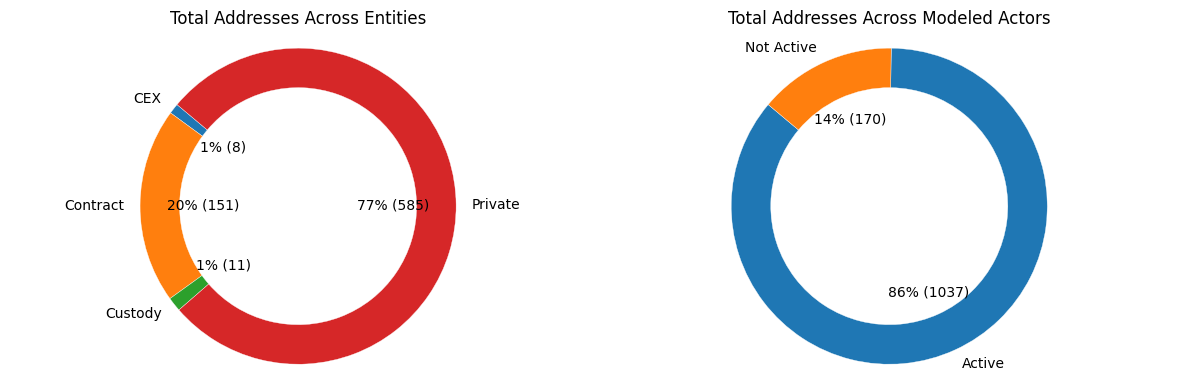

In [26]:
actors_start = actors_df[(actors_df["timestep"] == 0) & (actors_df["seed"] == SEED)].copy()
actors_start["is_private"] = "Active"
actors_start.loc[actors_start.entity.isin({"Contract", "CEX", "Custody"}), "is_private"] = "Not Active"

entity_summary = actors_start.groupby("entity").sum(numeric_only=True)
is_private_summary = actors_start.groupby("is_private").sum(numeric_only=True)

fig = create_donut_charts(
    [entity_summary, is_private_summary],
    ["count", "count"],
    ["Total Addresses Across Entities", "Total Addresses Across Modeled Actors"],
)

### Original Thresholds (Percent)

#### Veto Signalling:  3%

#### Rage Quit:  15%

### Effective Thresholds (Percent)

#### Veto Signalling:  6.80%

#### Rage Quit:  33.99%

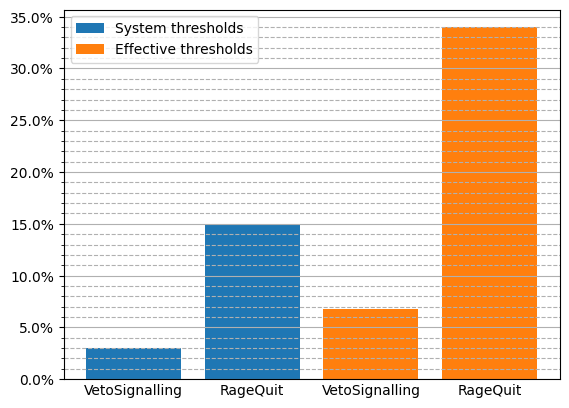

In [35]:
wallet_df = pd.read_csv(Path("data/stETH_token_distribution.csv"))
wallet_df.loc[wallet_df.type.isna(), "type"] = "Private"
wallet_type_summary = wallet_df.groupby("type").sum(numeric_only=True)
wallet_type_summary["wallet_count"] = wallet_df.groupby("type").count()["address"]

active_percent = wallet_type_summary["total"]["Private"] / wallet_type_summary["total"].sum()

default_percents = np.array([3, 15])

display(Markdown("### Original Thresholds (Percent)"))
display(Markdown(f"#### Veto Signalling:  {default_percents[0]}%"))
display(Markdown(f"#### Rage Quit:  {default_percents[1]}%"))

display(Markdown("### Effective Thresholds (Percent)"))
display(Markdown(f"#### Veto Signalling:  {(default_percents[0] / active_percent):.2f}%"))
display(Markdown(f"#### Rage Quit:  {(default_percents[1] / active_percent):.2f}%"))

plt.bar([0, 1], default_percents, label="System thresholds")
plt.bar([2, 3], default_percents / active_percent, label="Effective thresholds")
plt.xticks([0, 1, 2, 3], labels=["VetoSignalling", "RageQuit", "VetoSignalling", "RageQuit"])
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
plt.gca().tick_params(axis="x", which="both", length=0)
plt.grid(True, axis="y")
plt.gca().grid(True, axis="y", which="minor", linestyle="--")
plt.legend()
plt.show()

In [36]:
print(active_percent)

0.44128981432064446


In [28]:
def create_donut_charts_2(post_processing, donut_charts, monte_carlo_runs, timesteps):
    num_charts_per_run = len(donut_charts)
    fig, axs = plt.subplots(
        monte_carlo_runs, num_charts_per_run, figsize=(6 * num_charts_per_run, 4 * monte_carlo_runs)
    )

    for run in range(monte_carlo_runs):
        start_idx = run * timesteps
        end_idx = start_idx + timesteps

        for i, (labels, sizes, colors, title) in enumerate(donut_charts):
            values = [post_processing.loc[end_idx - 1, attr] for attr in sizes]
            total = sum(values)

            if monte_carlo_runs == 1 and num_charts_per_run == 1:
                ax = axs
            elif monte_carlo_runs == 1:
                ax = axs[i]
            else:
                ax = axs[run, i]

            ax.pie(
                values,
                labels=labels,
                colors=colors,
                autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
                startangle=140,
                wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
                textprops=dict(color="black", fontsize=10),
            )
            ax.set_title(title)
            ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()

In [29]:
post_processing = postprocessing(result)

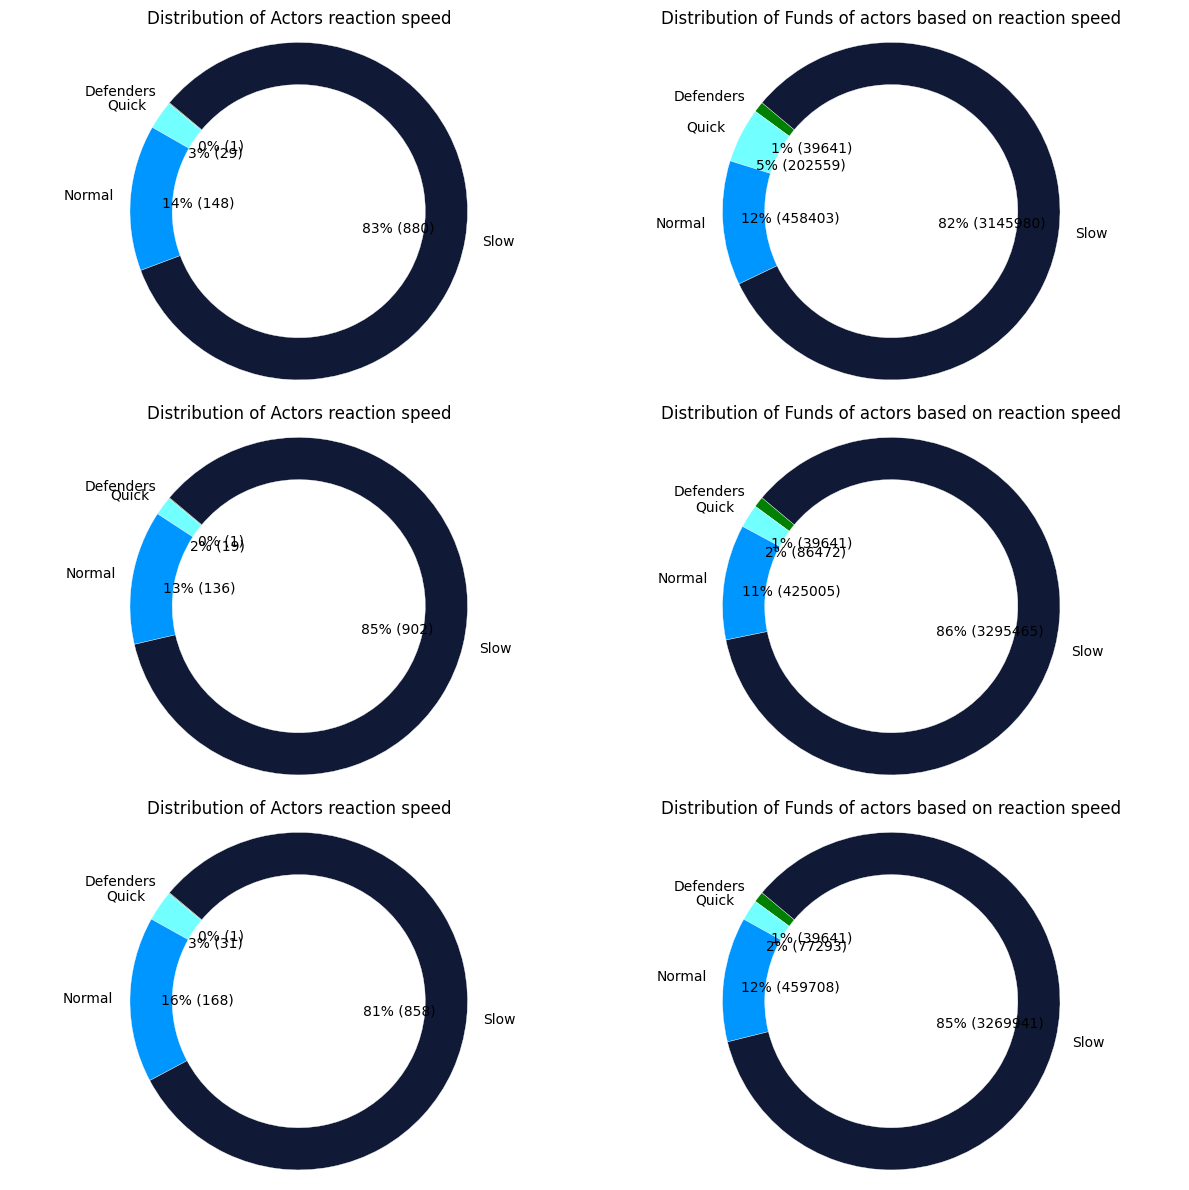

In [30]:
post_processing["total_quick_honest_actors_reaction_time"] = (
    post_processing["total_quick_actors_reaction_time"] - post_processing["total_attackers"]
)
post_processing["total_quick_honest_actors_funds"] = (
    post_processing["total_quick_actors_funds"] - post_processing["total_attackers_actors_funds"]
)


def generate_distribution(post_processing, labels, columns, colors, title):
    filtered_labels = []
    filtered_columns = []
    filtered_colors = []

    for label, column, color in zip(labels, columns, colors):
        value = post_processing[column]
        if (value != 0).any():
            filtered_labels.append(label)
            filtered_columns.append(column)
            filtered_colors.append(color)

    return (filtered_labels, filtered_columns, filtered_colors, title)


actors_distribution = generate_distribution(
    post_processing,
    ["Attackers (Quick)", "Defenders", "Quick", "Normal", "Slow"],
    [
        "total_attackers",
        "total_defenders",
        "total_quick_honest_actors_reaction_time",
        "total_normal_actors_reaction_time",
        "total_slow_actors_reaction_time",
    ],
    ["#D6292F", "green", "#72FFFF", "#0096FF", "#101A36"],
    "Distribution of Actors reaction speed",
)

funds_distribution = generate_distribution(
    post_processing,
    ["Attackers (Quick)", "Defenders", "Quick", "Normal", "Slow"],
    [
        "total_attackers_actors_funds",
        "total_defenders_actors_funds",
        "total_quick_honest_actors_funds",
        "total_normal_actors_funds",
        "total_slow_actors_funds",
    ],
    ["#D6292F", "green", "#72FFFF", "#0096FF", "#101A36"],
    "Distribution of Funds of actors based on reaction speed",
)

## add legend

fig = create_donut_charts_2(post_processing, [actors_distribution, funds_distribution], MONTE_CARLO_RUNS, TIMESTEPS)

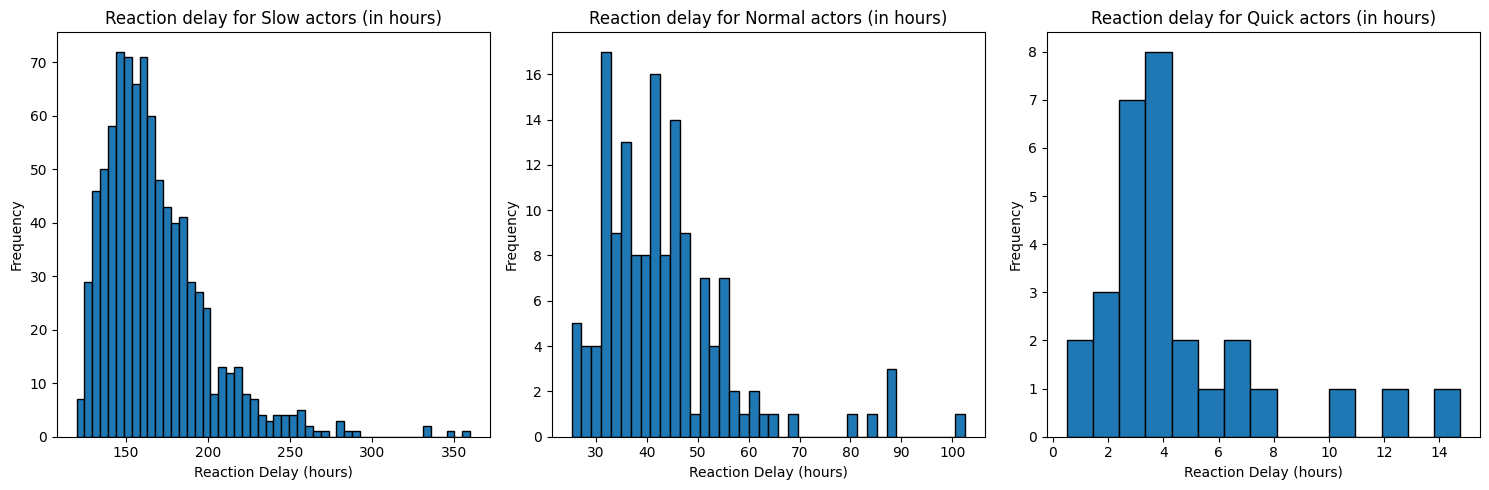

In [31]:
def plot_reaction_delay_histogram(actors_df, timestep, seed, reaction_times, time_unit, bins_list):
    actors_end = actors_df[(actors_df["timestep"] == timestep) & (actors_df["seed"] == seed)].copy()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, (reaction_time, bins) in enumerate(zip(reaction_times, bins_list)):
        reaction_delay_series = actors_end.loc[
            actors_end["reaction_time"] == "ReactionTime." + str(reaction_time), "reaction_delay"
        ]

        if time_unit == "hours":
            reaction_delay_series_converted = reaction_delay_series / 3600
            xlabel = "Reaction Delay (hours)"
            title = f"Reaction delay for {reaction_time} actors (in hours)"
        elif time_unit == "days":
            reaction_delay_series_converted = reaction_delay_series / (3600 * 24)
            xlabel = "Reaction Delay (days)"
            title = f"Reaction delay for {reaction_time} actors (in days)"
        else:
            raise ValueError("Invalid time unit. Use 'hours' or 'days'.")

        reaction_delay_series_converted.plot(kind="hist", bins=bins, edgecolor="black", ax=axes[i])
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(title)

    plt.tight_layout()
    plt.show()


plot_reaction_delay_histogram(actors_df, TIMESTEPS, SEED, ["Slow", "Normal", "Quick"], "hours", [50, 40, 15])

## add explanation about the distributions

#### Results Summary for Run 1

##### Time from maximum total health to maximum combined_percentage_locked: **-1356 hours** (-56.50 days)

##### Maximum percentage of rage quit support : **8.92 %**

##### Maximum number of locked tokens : **487013.29 stETH** and **134829.21 wstETH**

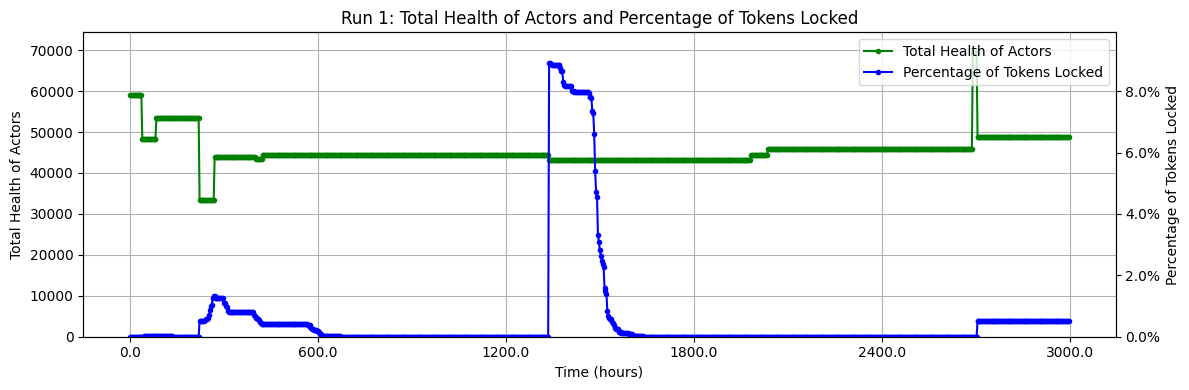

IndexError: range object index out of range

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display, Markdown

for run in range(MONTE_CARLO_RUNS):
    start_idx = run * TIMESTEPS
    end_idx = start_idx + TIMESTEPS

    total_stETH_balance = post_processing["total_stETH_balance"].iloc[start_idx:end_idx]
    total_stETH_locked = post_processing["total_stETH_locked"].iloc[start_idx:end_idx]
    total_wstETH_balance = post_processing["total_wstETH_balance"].iloc[start_idx:end_idx]
    total_wstETH_locked = post_processing["total_wstETH_locked"].iloc[start_idx:end_idx]
    total_actors_damaged = post_processing["total_actors_damaged"].iloc[start_idx:end_idx]
    total_actors_health = post_processing["total_actors_health"].iloc[start_idx:end_idx]
    total_actors_recovery = post_processing["total_actors_recovery"].iloc[start_idx:end_idx]
    rage_quit_support = post_processing["rage_quit_support"].iloc[start_idx:end_idx]
    timesteps = range(len(total_stETH_balance))

    combined_balance = total_stETH_balance + total_wstETH_balance + total_stETH_locked + total_wstETH_locked
    combined_locked = total_stETH_locked + total_wstETH_locked

    percentage_locked = [
        (locked / balance) if balance != 0 else 0 for locked, balance in zip(combined_locked, combined_balance)
    ]

    max_total_health_idx = total_actors_health.idxmax()
    max_total_health_ts = timesteps[max_total_health_idx]

    max_combined_percentage_locked_idx = percentage_locked.index(max(percentage_locked))
    max_combined_percentage_locked_ts = timesteps[max_combined_percentage_locked_idx]

    time_difference = max_combined_percentage_locked_ts - max_total_health_ts
    time_difference_hours = time_difference * 3
    time_difference_days = time_difference_hours / 24

    display(Markdown(f"#### Results Summary for Run {run + 1}"))
    display(
        Markdown(
            f"##### Time from maximum total health to maximum combined_percentage_locked: **{time_difference_hours} hours** ({time_difference_days:.2f} days)"
        )
    )
    display(Markdown(f"##### Maximum percentage of rage quit support : **{rage_quit_support.max():.2f} %**"))
    display(
        Markdown(
            f"##### Maximum number of locked tokens : **{total_stETH_locked.max():.2f} stETH** and **{total_wstETH_locked.max():.2f} wstETH**"
        )
    )

    fig, ax1 = plt.subplots(figsize=(12, 4))

    # Plot total_actors_health on the left y-axis
    ax1.plot(timesteps, total_actors_health, color="green", label="Total Health of Actors", marker="o", markersize=3)
    max_total_health = total_actors_health.max()
    max_total_health_rounded = max_total_health + 5000

    ax1.set_xlabel("Time (hours)")
    ax1.set_ylabel("Total Health of Actors")
    ax1.set_ylim(0, max_total_health_rounded)  # Set y-axis limit based on maximum health
    ax1.yaxis.set_major_formatter(ticker.ScalarFormatter())

    # Create a secondary y-axis for percentage_locked
    ax2 = ax1.twinx()
    ax2.plot(timesteps, percentage_locked, color="blue", label="Percentage of Tokens Locked", marker="o", markersize=3)
    ax2.set_ylabel("Percentage of Tokens Locked")

    # Calculate the maximum value of percentage_locked and set the y-axis limit
    max_percentage_locked = max(percentage_locked)
    max_percentage_locked_rounded = max_percentage_locked + 0.01
    ax2.set_ylim(0, max_percentage_locked_rounded)
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper right")

    ax1.set_title(f"Run {run + 1}: Total Health of Actors and Percentage of Tokens Locked")
    ax1.grid(True)
    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))

    plt.tight_layout()
    plt.show()